In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# импорт данных
df = pd.read_csv('dataset/train.csv')

In [3]:
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
df.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [6]:
#Выбираем поддиапазон данных
#Index 11856 указывает на конец 2013 года
df = pd.read_csv('dataset/train.csv', nrows = 11856)

In [7]:
#Создание обучающего и тестового наборов
#Индекс 10392 указывает на конец октября 2013 года
train=df[0:10392]
test=df[10392:]

In [8]:
# Агрегирование набора данных на ежедневной основе
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

<ipython-input-8-671d34b67862>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')
<ipython-input-8-671d34b67862>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
<ipython-input-8-671d34b67862>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')


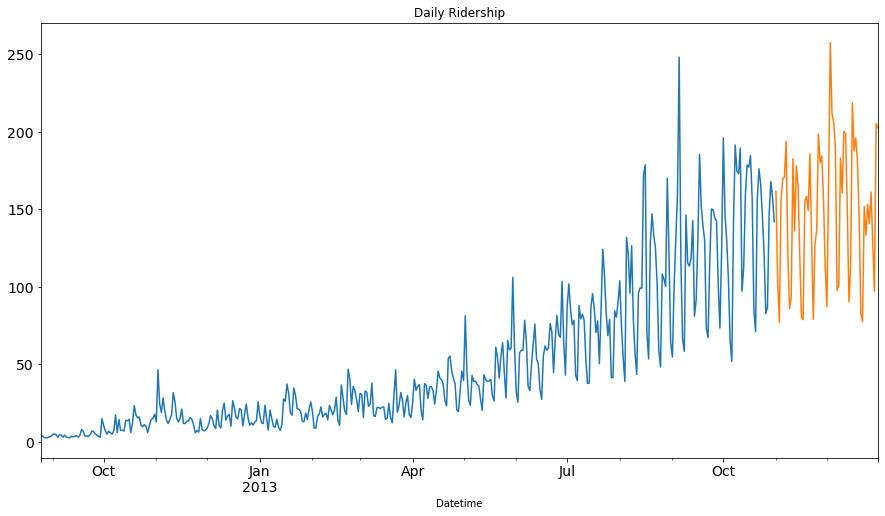

In [9]:
#Строим график
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

In [10]:
df

,ID,Count
Datetime,,
2012-08-25,11.5,3.166667
2012-08-26,35.5,3.666667
2012-08-27,59.5,2.583333
2012-08-28,83.5,2.416667
2012-08-29,107.5,2.500000
...,...,...
2013-12-27,11747.5,161.166667
2013-12-28,11771.5,128.500000
2013-12-29,11795.5,97.083333


In [13]:
from statsmodels.tsa.api import ExponentialSmoothing

### Метод 1. Начинаем с наивного подхода

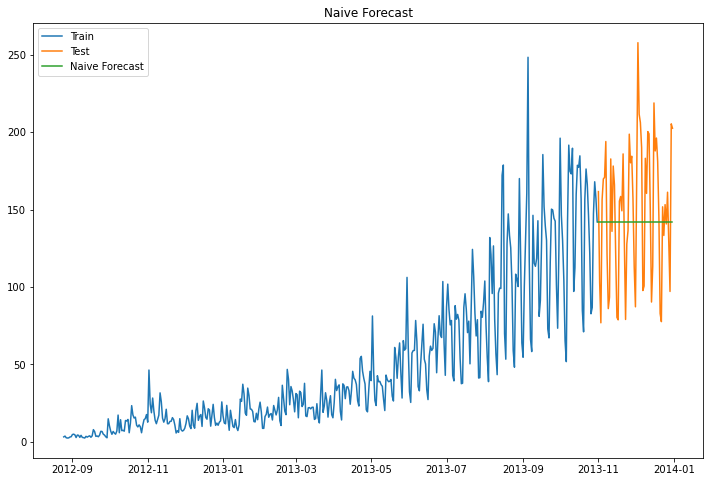

In [19]:
dd = np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

43.91640614391676


### Метод 2. Простое среднее

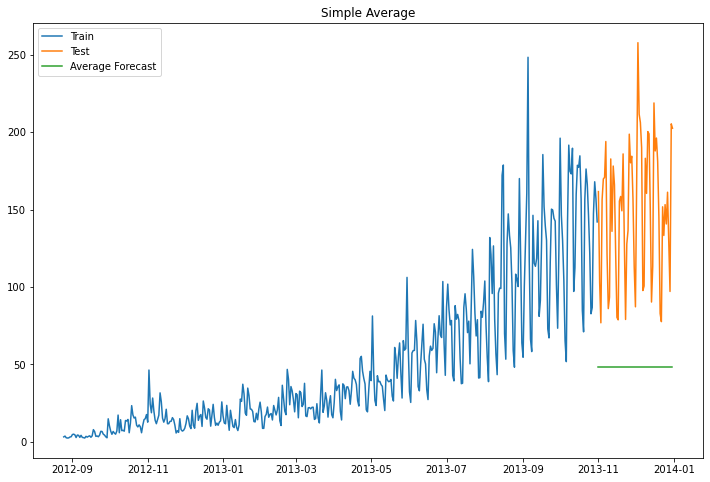

In [25]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title("Simple Average")
plt.show()

In [23]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)

109.88526527082863


### Метод 3. Скользящее среднее

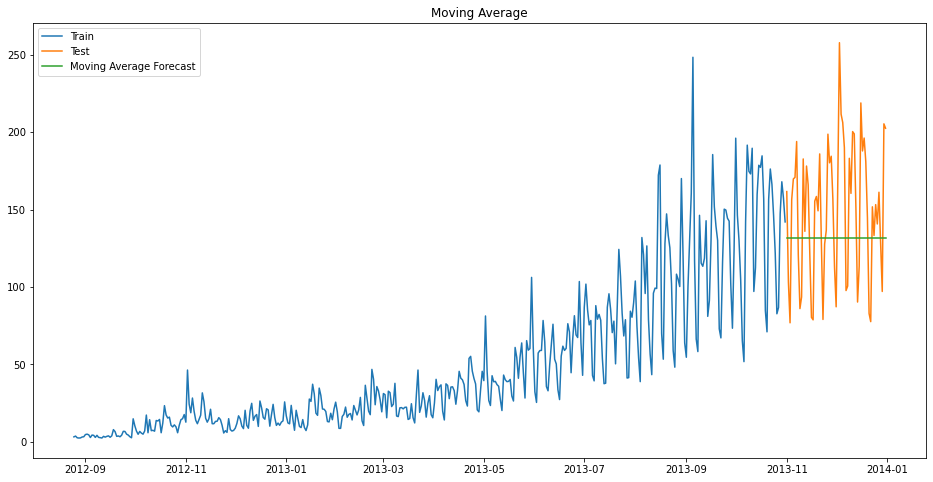

In [29]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast']=train['Count'].rolling(60).mean().iloc[-1]  # Мы выбрали данные только за последние 2 месяца
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title("Moving Average")
plt.show()

In [30]:
rms=sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

46.72840725106963


### Метод 4. Простое экспоненциальное сглаживание

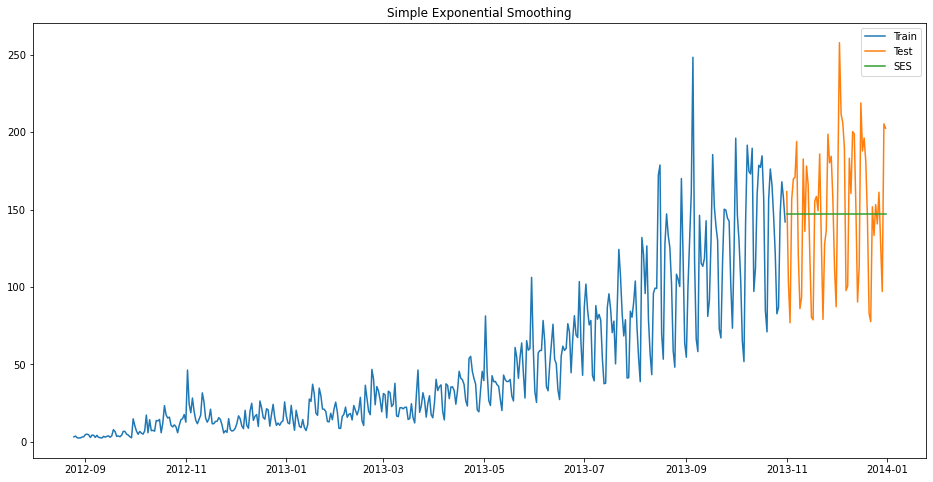

In [32]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2=SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.title("Simple Exponential Smoothing")
plt.show()

In [33]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

43.357625225228155


### Метод 5.  Метод линейного тренда Хольта

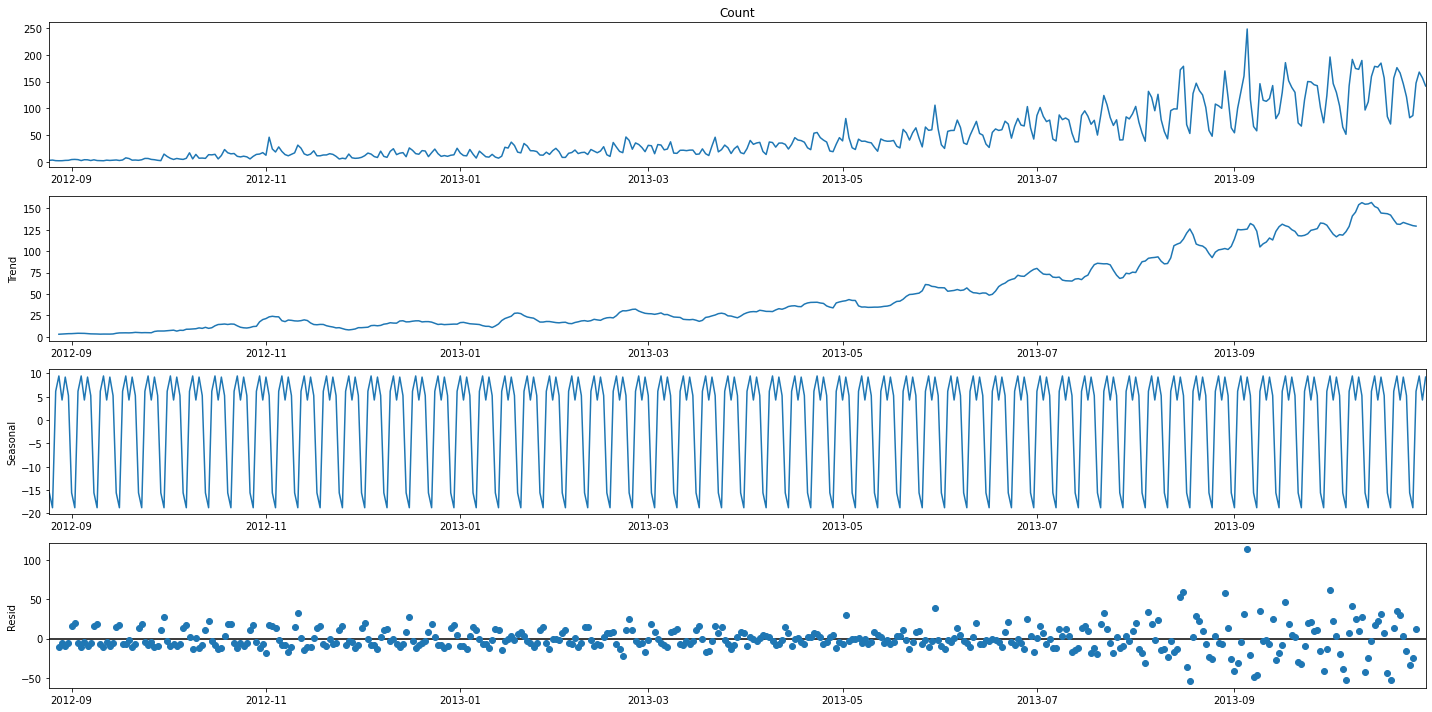

In [44]:
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (20,10)
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

<ipython-input-46-d8262f3c6a91>:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1=Holt(np.asarray(train['Count'])).fit(smoothing_level=0.3,smoothing_slope = 0.1)


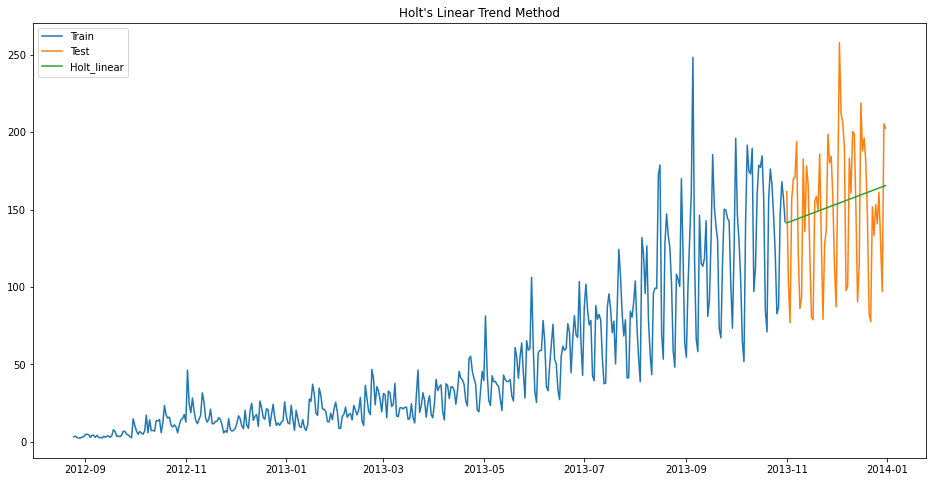

In [46]:
y_hat_avg = test.copy()

fit1=Holt(np.asarray(train['Count'])).fit(smoothing_level=0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("Holt's Linear Trend Method")
plt.show()

In [47]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

43.056259611507286


### Метод 6. Метод Холта-Винтера

C:\Programming\Anaconda\envs\BigData\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


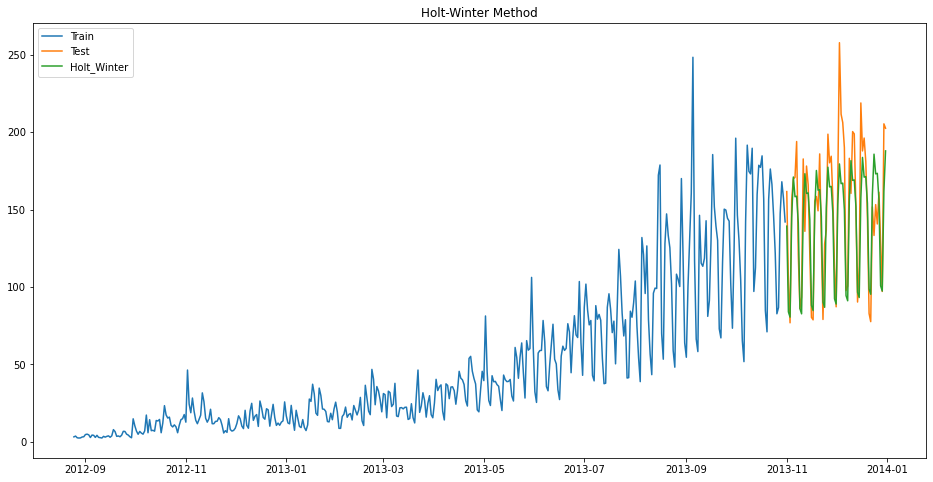

In [50]:
y_hat_avg = test.copy()
fit1=ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
# Мы выбрали seasonal_period = 7, поскольку данные повторяются еженедельно
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.title("Holt-Winter Method")
plt.show()

In [49]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)

25.264496449543422


### Метод 7. ARIMA

C:\Programming\Anaconda\envs\BigData\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


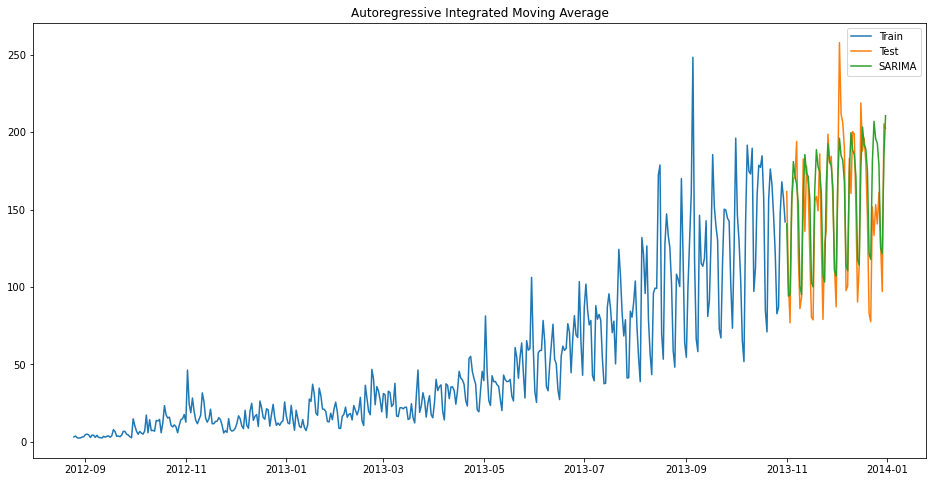

In [52]:
y_hat_avg = test.copy()
fit1=sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.title("Autoregressive Integrated Moving Average")
plt.show()

In [53]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rms)

26.053692092579592
